# Table of Contents
  * [Sending the packets](#sending_the_packets)
  * [Capturing the packets](#capturing_the_packets)
  * [Creating the pandas dataframe](#creating_the_pandas_dataframe)
  * [Analizing the data](#analizing-data)

# Sending the packets <a id="sending_the_packets"></a>

To change the datarate and the txpower in the router, ssh into it and run the following commands

```bash
# To change the data rate
wl rate 11

# To change the power
wl txpwr1 -m 60 # mW
# Or in dBm
wl txpwr1 17.75 # 60 mW

# To check the transission power
wl txpwrlimit
```

All the available commands are here: http://www.dd-wrt.com/wiki/index.php/Wl_command

## Transmissions:

A raspberry pi is broadcasting or unicasting packets which payloads consisting on just 0 bits

The code for broadcasting is;

```python
# Send UDP broadcast packets

import sys, time, array, os
from socket import *

rates = ['1', '2', '5.5', '6', '9', '11', '12', '18', '24', '36', '48', '54']
rates_i = 0
MYPORT = 53524
# dest_ip = '<broadcast>'
# My pc
# dest_ip = '192.168.1.124'
# Measurements PC
dest_ip = '192.168.1.130'
data = "0"*2500 # n/2 * 8 [bits] in total

def change_ap_rate ():
    global rates_i
    global rates
    rate = rates[rates_i]
    command = 'ssh root@192.168.1.1 \'wl rate ' + rate + '\''
    os.popen(command)
    print ('Changing rate to {}Mbps'.format(rate) + ' using the following command '  + command)
    # Increase the index for the next function call
    rates_i += 1
    if rates_i >= len(rates):
        rates_i = 0

# Check if n minute passed
def has_minutes_passed(oldepoch,n):
    return time.time() - oldepoch >= n*60

def main():
    # Initialize the rate to 1 Mbps
    change_ap_rate()
    pkts_sent = 0
    oldepoch = time.time()
    s = socket(AF_INET, SOCK_DGRAM)
    s.bind(('', 0))
    s.setsockopt(SOL_SOCKET, SO_BROADCAST, 1)
    global data
    data= data.decode('hex')

    while 1:
        s.sendto(data, (dest_ip, MYPORT))
        pkts_sent += 1
        #print data
        # 5 minutes passed
        if (has_minutes_passed(oldepoch,5)):
            oldepoch = time.time()
            print (pkts_sent)
            pkts_sent = 0
            change_ap_rate()

        time.sleep(0.05)
        #break

if __name__ == "__main__":
    main()
```

# Capturing the packets <a id="capturing_the_packets"></a>

To capture the packets it is needed to set the NIC in monitor mode. The instructions are [here](https://sandilands.info/sgordon/capturing-wifi-in-monitor-mode-with-iw)

## Setting up the monitor interface

The only special consideration is that you need to include the flag for capturing packets with the FCS fail:

```bash
sudo iw phy phy0 interface add mon0 type monitor flags fcsfail
```

I do the following when using the USB dongle

```bash
sudo iw phy phy1 interface add mon0 type monitor flags fcsfail
sudo iw dev wlp0s26u1u2 del
sudo ifconfig mon0 up
# Set it to channel 6
sudo iw dev mon0 set freq 2437
```

### Troubleshooting: type doesn't change to monitor from managed

If the type does not change, it is most likely because network manager is controlling the interface. For solving this, one must remove the interface from the `/etc/NetworkManager/NetworkManager.conf` file.

Add these lines to said file:

```
[main]
plugins=keyfile

[keyfile]
unmanaged-devices=mac:xx:xx:xx:xx:xx:xx
```

The correct MAC address can be found running the command `iw dev`

## Tshark for packet capturing

The script used for capturing the packets is the following
```bash
if [ "$#" -ne 2 ]; then
    echo "Input the mw and the data rate as arguments"
    echo "Usage: ./capture.sh xx yy"
    echo "xx: mw"
    echo "yy: mbps"
    exit 1
fi

tshark -i mon0 -f "udp && host 192.168.1.144 && port 53524" \
    -w "$(date +%F_%H_%M)_$1mw_$2mbps.pcapng" -T fields -E separator=' ; ' \
    -e wlan.fcs_bad -e radiotap.dbm_antsignal -e radiotap.datarate
```

* -i interface
* -f is the capture filter (we only want to capture the UDP packets sent from the raspi)
* -w name of the output file
* -T We want to display some packets fields in console
* -e specify which fields (fcs broken and signal strength in dBm)

# Creating the pandas dataframe <a id="creating_the_pandas_dataframe"></a>

When I tried to create a dataframe from a huge capture file (3.9 GB) in Ipython notebook,
the websocket timed out and the kernel was killed. Therefore, I moved to a separate python
script the creation of the dataframe.

The script is the following: `make_dataframe.py`

```python
import pyshark
import pandas as pd
import numpy as np

# Some constants

# TOTAL_BITS = 400
TOTAL_BITS = 10000
AP_MAC = '58:6d:8f:d3:5e:70'

# ## Loading the captured packets

file = '2015-12-09_18_33_60mw_all_night2mbps.pcapng' # Big automated
# file = '2015-12-09_18_33_60mw_all_night2mbps.pcapng' # ALL NIGHT!

cap = pyshark.FileCapture(file)

# ## Extracting information

# ### Filter the CRC broken packets

# We use pandas to build the data frame with some usefull columns:

# Broken data as a string
data = []
data_rate = []
rssi = []
tx_mac = []
time_rel = []
# for pkt in broken_pkts:
for pkt in cap:
    if pkt.wlan.fcs_bad == '1':
# for pkt in pkts:
        # Data
        try:
            data.append(pkt.data.data.replace(':',''))
        except(AttributeError):
            continue
        # Data rate
        try:
            data_rate.append(float(pkt.radiotap.datarate))
        except:
            data.pop()
            continue
        # RSSI
        try:
            rssi.append(int(pkt.radiotap.dbm_antsignal))
        except:
            data.pop()
            data_rate.pop()
            continue
        # Transmitter MAC Address
        try:
            tx_mac.append(pkt.wlan.ta)
        except:
            data.pop()
            data_rate.pop()
            rssi.pop()
            continue
        # Relative time
        try:
            time_rel.append(pkt.frame_info.time_relative)
        except:
            data.pop()
            data_rate.pop()
            rssi.pop()
            tx_mac.pop()
            continue


fields={'Data':data,'Data_rate':data_rate,'RSSI':rssi,'Tx_mac':tx_mac,'Time':time_rel}
p_data = pd.DataFrame(fields)
# ==========

# Add a column stating if the AP sent the packet
p_data['AP_pkt'] = p_data['Tx_mac'].apply(lambda x: x == '58:6d:8f:d3:5e:70')
# ==========


# Add a column with Binary Data
def str2bin(number):
    decimal_number = int(number,16)
    # Do not return the '0b' at the beginning and fill with zeroes
    return bin(decimal_number)[2:].zfill(8)

def data_to_bin(data):
    return [str2bin(data[byte : byte+2]) for byte in range(0, len(data),2)]

def bytes_to_binarray(list_of_bytes):
    temp_str = ''
    for byte in list_of_bytes:
        temp_str = temp_str + byte
    return temp_str

p_data['Data_bin'] = p_data['Data'].apply(data_to_bin)
p_data['Data_bin'] = p_data['Data_bin'].apply(bytes_to_binarray)
# ==========

# Add a column stating if the data has the right length
# p_data['Right_Length'] = p_data['Data'].apply(lambda x: len(x) == 100)
p_data['Right_Length'] = p_data['Data_bin'].apply(lambda x: len(x) == TOTAL_BITS)
# ==========

# Add column with number of bits flipped
p_data['Flipped_bits'] = p_data['Data_bin'].apply(lambda x: x.count('1'))
# ==========

# Save DF
p_data.to_msgpack('output.msg')
# ==========
```

# Analyzing the data <a id="analizing-data"></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
import os

# Some CONSTANTS
TOTAL_BITS = 10000
AP_MAC = '58:6d:8f:d3:5e:70'

# Original data file
file = './data/2015-12-09_17_12_60mw_all_nightmbps.pcapng'
# Pre-processed data
p_data = pd.read_pickle('./across_rooms_automated_timed.pickle')

In [3]:
# Group the packets in right/wrong length and count the number of occurences
lengths = p_data.groupby(['Right_Length']).size()
# Right length
total_broken_pkts_true_length = lengths[True]
total_broken_pkts_true_length

# Wrong length
total_broken_pkts_false_length = lengths[False]
total_broken_pkts_false_length

982

In [4]:
# # Total packets captured sent from the AP
# # We get this number doing a system call to tshark: tshark -r 2015-12-07_11_51.pcapng -Y 'wlan.ta==58:6d:8f:d3:5e:70 && wlan.fcs_bad==true' | wc -l
command = 'tshark -r ' + str(file) + ' -Y \'wlan.ta==' + AP_MAC + '\' | wc -l'
total_pkts_AP = np.int64(os.popen(command).read())
print ("Total packets = {}".format(total_pkts_AP))

Total packets = 142908


In [5]:
# Percentage of useful broken packets. 
# I.e., *Sent from AP; 
#       *Correct length; 
#       *IP from Raspi (@capture time); 
#       *Right port (@capture time)
total_useful_broken_packets = np.int64(len(p_data[(p_data['Right_Length'] == True) &(p_data['AP_pkt'] == True)].index))
percentage_broken_pkts = (total_useful_broken_packets * 100.0) / total_pkts_AP
print ("total_useful_broken_packets = {}".format(total_useful_broken_packets))
print ("Percentage of broken packets = {}".format(percentage_broken_pkts))

total_useful_broken_packets = 27506
Percentage of broken packets = 19.24734794413189


In [6]:
# Extract all the measured data rates
data_rates = pd.unique(p_data[p_data['AP_pkt'] == True].Data_rate.ravel())
#print data_rates
#print type(data_rates)


In [7]:
pkts_captured=[]
for dr in data_rates:
    command = 'tshark -r ' + file + ' -Y \'wlan.ta==' + AP_MAC +' && wlan_radio.data_rate == {}'.format(dr) + '\' | wc -l'
    pkts_captured.append(np.int64(os.popen(command).read()))

print ("pkts_captured = {}".format(pkts_captured))

pkts_captured = [15842, 13062, 12039, 9815, 6470, 6005, 6128, 5986, 6062, 7947, 16433, 37119]


In [8]:
# Empty vector
total_flips_occurences = [0]*TOTAL_BITS

# Operate only over data packets of the right size
right_size_data = p_data[(p_data['Right_Length'] == True) & (p_data['AP_pkt'] == True)]['Data_bin']

for row in right_size_data:
    # Traverse the vector
    for i,x in enumerate(row):
        # If the value is a '1' add one to the vector of flips_occurences
        if x == '1':
            total_flips_occurences[i] = total_flips_occurences[i] + 1
            
#total_flips_occurences

In [9]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import binascii
import timeit
import os

#fig = plt.figure()
#plt.plot(range(len(total_flips_occurences)), total_flips_occurences / (total_useful_broken_packets*1.0))
#plt.show()

In [10]:
def flips_counter(rr):
    flips = [0]*TOTAL_BITS
    for row in rr['Data_bin']:
        # Traverse the vector
        for i,x in enumerate(row):
            # If the value is a '1' add one to the vector of flips_occurences
            if x == '1':
                flips[i] = flips[i] + 1
    return flips

# For packets coming from the AP and with the right length count the number of bits flipped
flips_occurences = p_data[(p_data['Right_Length'] == True) & (p_data['AP_pkt'] == True)][['Data_bin','Data_rate']]
flips_occurences = flips_occurences.groupby('Data_rate').apply(flips_counter)
print ("flips_occurences = {}".format(flips_occurences))

flips_occurences = Data_rate
1.0     [11, 12, 13, 6, 10, 8, 8, 9, 13, 11, 12, 14, 1...
2.0     [4, 2, 4, 4, 5, 6, 8, 2, 4, 4, 4, 3, 6, 3, 4, ...
5.5     [2, 1, 1, 1, 3, 1, 1, 2, 3, 1, 3, 4, 2, 3, 2, ...
6.0     [1, 1, 1, 2, 1, 0, 2, 0, 2, 1, 1, 1, 1, 2, 1, ...
9.0     [10, 5, 5, 5, 5, 2, 4, 4, 16, 15, 20, 19, 9, 1...
11.0    [1, 0, 0, 0, 1, 0, 2, 0, 1, 1, 1, 2, 2, 1, 0, ...
12.0    [2, 4, 2, 2, 3, 2, 3, 3, 3, 2, 3, 3, 2, 1, 5, ...
18.0    [1, 3, 0, 2, 1, 1, 0, 1, 1, 2, 1, 0, 1, 2, 1, ...
24.0    [0, 1, 0, 1, 0, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, ...
36.0    [0, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, ...
48.0    [0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...
54.0    [55, 53, 45, 61, 52, 23, 19, 58, 32, 35, 32, 3...
dtype: object


In [11]:
# Calculate the useful packets per data rate and rssi
useful_broken_packets = p_data[(p_data['Right_Length'] == True) & (p_data['AP_pkt'] == True)].groupby('Data_rate').size()
#print useful_broken_packets

df_useful_broken_packets = pd.DataFrame(useful_broken_packets,columns=['Useful_broken_packets'])
#print df_useful_broken_packets

# Normalize the number of bits flipped by the total useful broken packets at that data rate
flips_occurences_norm = flips_occurences.copy()
#print flips_occurences_norm
it = 0
for row in flips_occurences:
    flips_occurences_norm.loc[data_rates[it]] = row / (useful_broken_packets.loc[data_rates[it]] * 1.0)
    it += 1

print ("flips_occurences = {}".format(flips_occurences))
print ("useful_broken_packets = {}".format(useful_broken_packets))
#print flips_occurences_norm

flips_occurences_norm.to_pickle('flips_occurences_norm.df')

flips_occurences = Data_rate
1.0     [11, 12, 13, 6, 10, 8, 8, 9, 13, 11, 12, 14, 1...
2.0     [4, 2, 4, 4, 5, 6, 8, 2, 4, 4, 4, 3, 6, 3, 4, ...
5.5     [2, 1, 1, 1, 3, 1, 1, 2, 3, 1, 3, 4, 2, 3, 2, ...
6.0     [1, 1, 1, 2, 1, 0, 2, 0, 2, 1, 1, 1, 1, 2, 1, ...
9.0     [10, 5, 5, 5, 5, 2, 4, 4, 16, 15, 20, 19, 9, 1...
11.0    [1, 0, 0, 0, 1, 0, 2, 0, 1, 1, 1, 2, 2, 1, 0, ...
12.0    [2, 4, 2, 2, 3, 2, 3, 3, 3, 2, 3, 3, 2, 1, 5, ...
18.0    [1, 3, 0, 2, 1, 1, 0, 1, 1, 2, 1, 0, 1, 2, 1, ...
24.0    [0, 1, 0, 1, 0, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, ...
36.0    [0, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, ...
48.0    [0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...
54.0    [55, 53, 45, 61, 52, 23, 19, 58, 32, 35, 32, 3...
dtype: object
useful_broken_packets = Data_rate
1.0      4168
2.0      1446
5.5       472
6.0       480
9.0       602
11.0      173
12.0      278
18.0      130
24.0      216
36.0      306
48.0     2204
54.0    17031
dtype: int64


ignore_index = []
data_rates_plot = [  6.   9.  12.  18.  24.  36.  48.  54.]


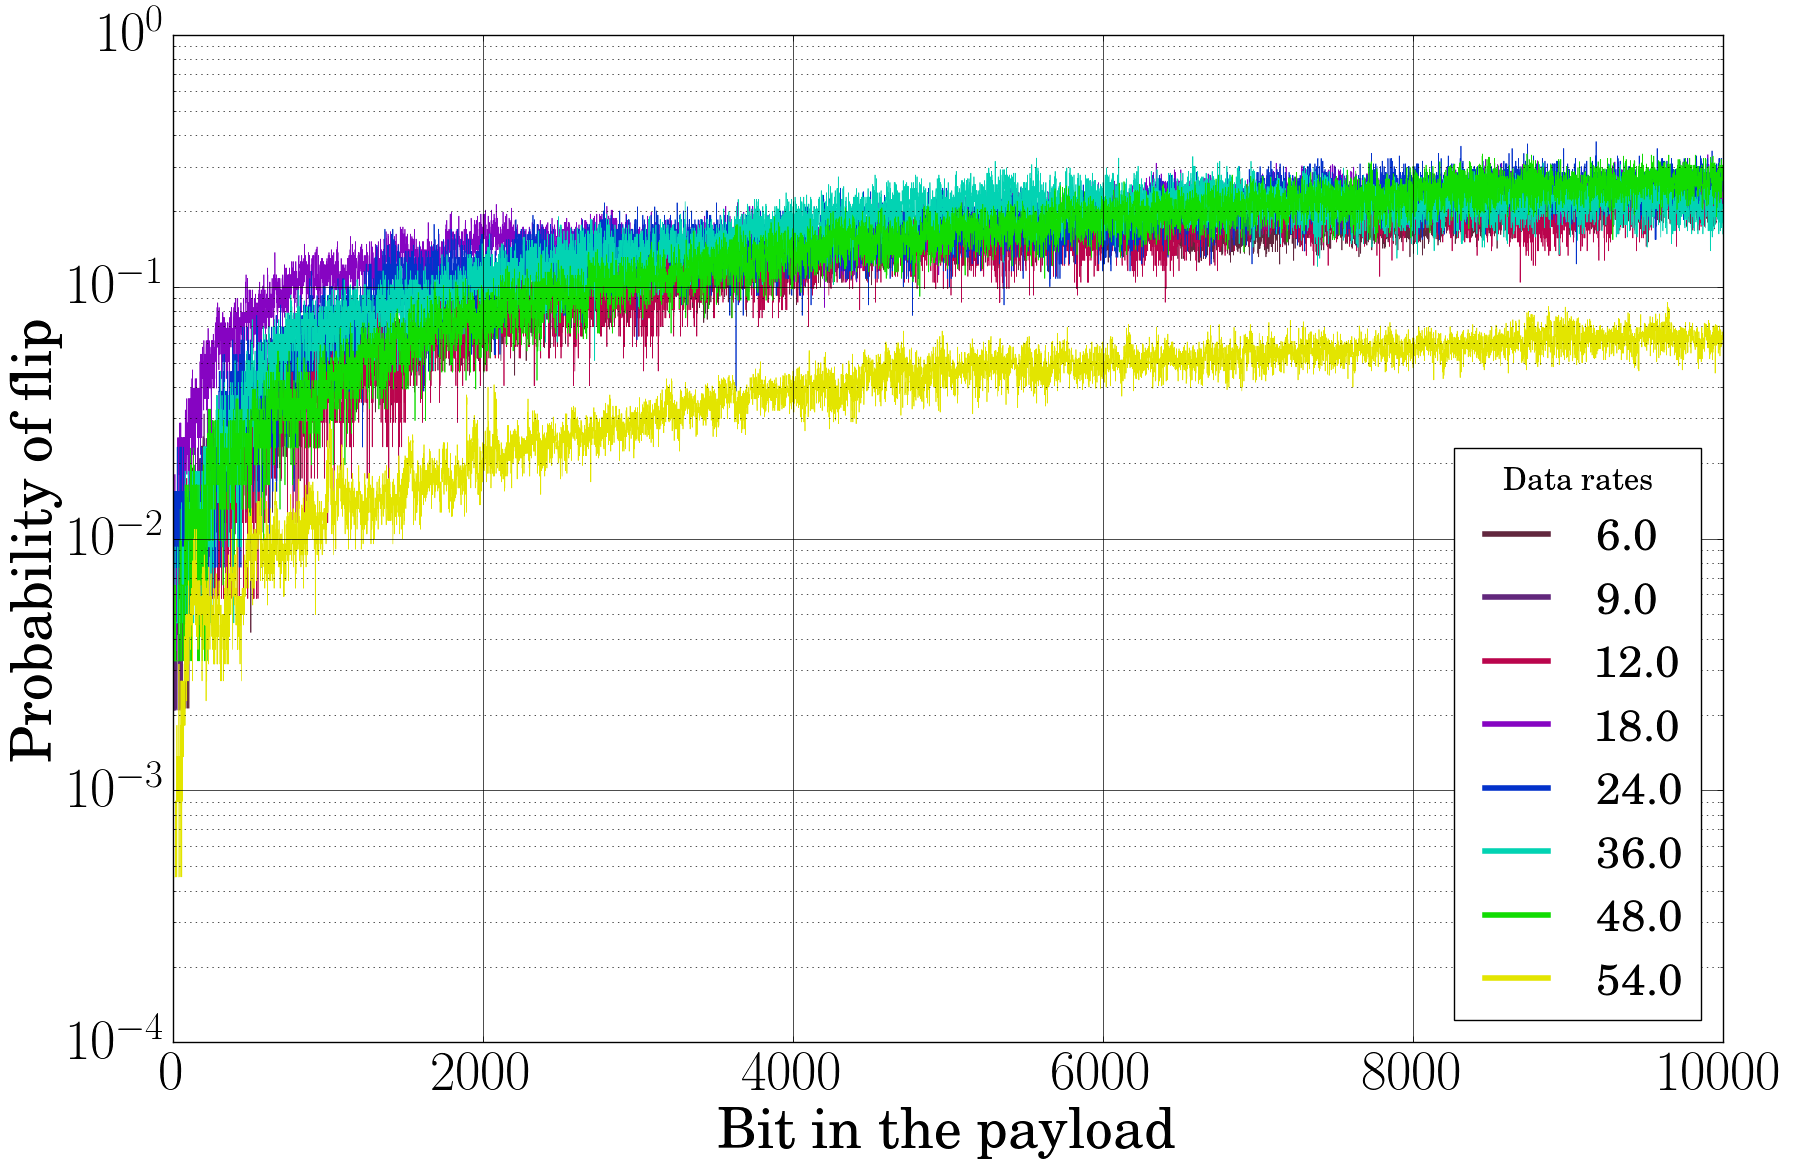

In [89]:
%matplotlib inline

def get_color():
    #for item in ('b','g','r','c','m','y','k','#F0A804','#99FF00','#FF6600','#8C5757','#F200FF','#808080'):
    #for item in ('#E3E500','#11DC01','#02D3B3','#0332CB','#8604C2','#BA054D','#62277C','#62273E'):
    for item in ('#62273E','#62277C','#BA054D','#8604C2','#0332CB','#02D3B3','#11DC01','#E3E500'):
        yield item

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import binascii
import timeit
import os

# Some CONSTANTS
TOTAL_BITS = 10000
AP_MAC = '58:6d:8f:d3:5e:70'

# -- Ploting parameters
#
######################### PLOTTING SETTINGS ################################
font_size = 40
#A small dictionary to set the font style
font = {'family': 'serif',
       'weight': 'medium',
       'style': 'normal',
       'size': font_size}
plt.rc('font', **font)
plt.rc('text', usetex=True) #For the LaTeX rendering
#
plt.rc('xtick', labelsize=font_size)
plt.rc('ytick', labelsize=font_size)

plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['figure.figsize'] = 20, 13
plt.rcParams.update({'font.size': 22})

color = get_color()
#fig = plt.figure()
seq = np.arange(TOTAL_BITS)
#print data_rates

# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~  
# Data filtering
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 

# Drop elements associating with rates 1. 2. 11., because they don't belong to 802.11g
index = [0, 1, 2, 5]
data_rates_new = np.delete(data_rates, index)
#print data_rates_new

flips_occurences_norm = pd.read_pickle('flips_occurences_norm.df')
#print flips_occurences_norm

#print flips_occurences_norm
flips_occurences_norm = flips_occurences_norm.drop(flips_occurences_norm.index[0])
flips_occurences_norm = flips_occurences_norm.drop(flips_occurences_norm.index[0])
flips_occurences_norm = flips_occurences_norm.drop(flips_occurences_norm.index[2])
#print flips_occurences_norm


# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~  
# Plot
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 

ignore_index = []
start = 0
stop = 7
i = 0
for row in flips_occurences_norm: 
    if i < start:
        ignore_index.append(i)
        i += 1        
        continue
    plt.semilogy(seq, row, next(color))
    #plt.loglog(seq, row, next(color))
    if i == stop:
        break;
    i += 1

print ("ignore_index = {}".format(ignore_index))
data_rates_plot = np.delete(data_rates_new, ignore_index)
print ("data_rates_plot = {}".format(data_rates_plot))
    
#plt.figure(figsize=(100,7))
#plt.savefig("figure.png",format="png", dpi=600)


# Preparation
#fig.set_dpi(600)
lHandler = plt.legend(data_rates_plot.astype('str'),loc='best',title='Data rates', fontsize=32)
#
plt.grid(linestyle='-')
plt.grid(which='minor')
#
plt.xlabel("Bit in the payload", fontsize=40)
plt.ylabel("Probability of flip", fontsize=40)
#
for legobj in lHandler.legendHandles:
    legobj.set_linewidth(4.0)

plt.savefig("wifi_bit_flip.pdf", dpi=300, format='pdf')

# Range
#axes = plt.gca()
#axes.set_xlim([1000,1100])
#plt.title('Probabilty of individial bit flips in a broken packet for different data rates. Payload size: {} bits'.format(TOTAL_BITS))


In [13]:
avrg_number_flipped_bits = p_data[(p_data['Right_Length'] == True) & (p_data['AP_pkt'] == True)][['Flipped_bits','Data_rate']]
avrg_number_flipped_bits = avrg_number_flipped_bits.groupby('Data_rate').mean()
avrg_number_flipped_bits

avrg_number_flipped_bits.columns=['Avrg_flipped_bits']
avrg_number_flipped_bits['Avrg_flipped_bits_p'] = (avrg_number_flipped_bits * 100.0) / TOTAL_BITS
avrg_number_flipped_bits
df_data_rate = pd.concat([df_useful_broken_packets,avrg_number_flipped_bits],axis=1)
df_data_rate['Pkts_captured']= pkts_captured
df_data_rate['Useful_broken_packets_p'] = df_data_rate.Useful_broken_packets / df_data_rate.Pkts_captured * 100
df_data_rate = df_data_rate[['Pkts_captured','Useful_broken_packets','Useful_broken_packets_p','Avrg_flipped_bits','Avrg_flipped_bits_p']]
#df_data_rate


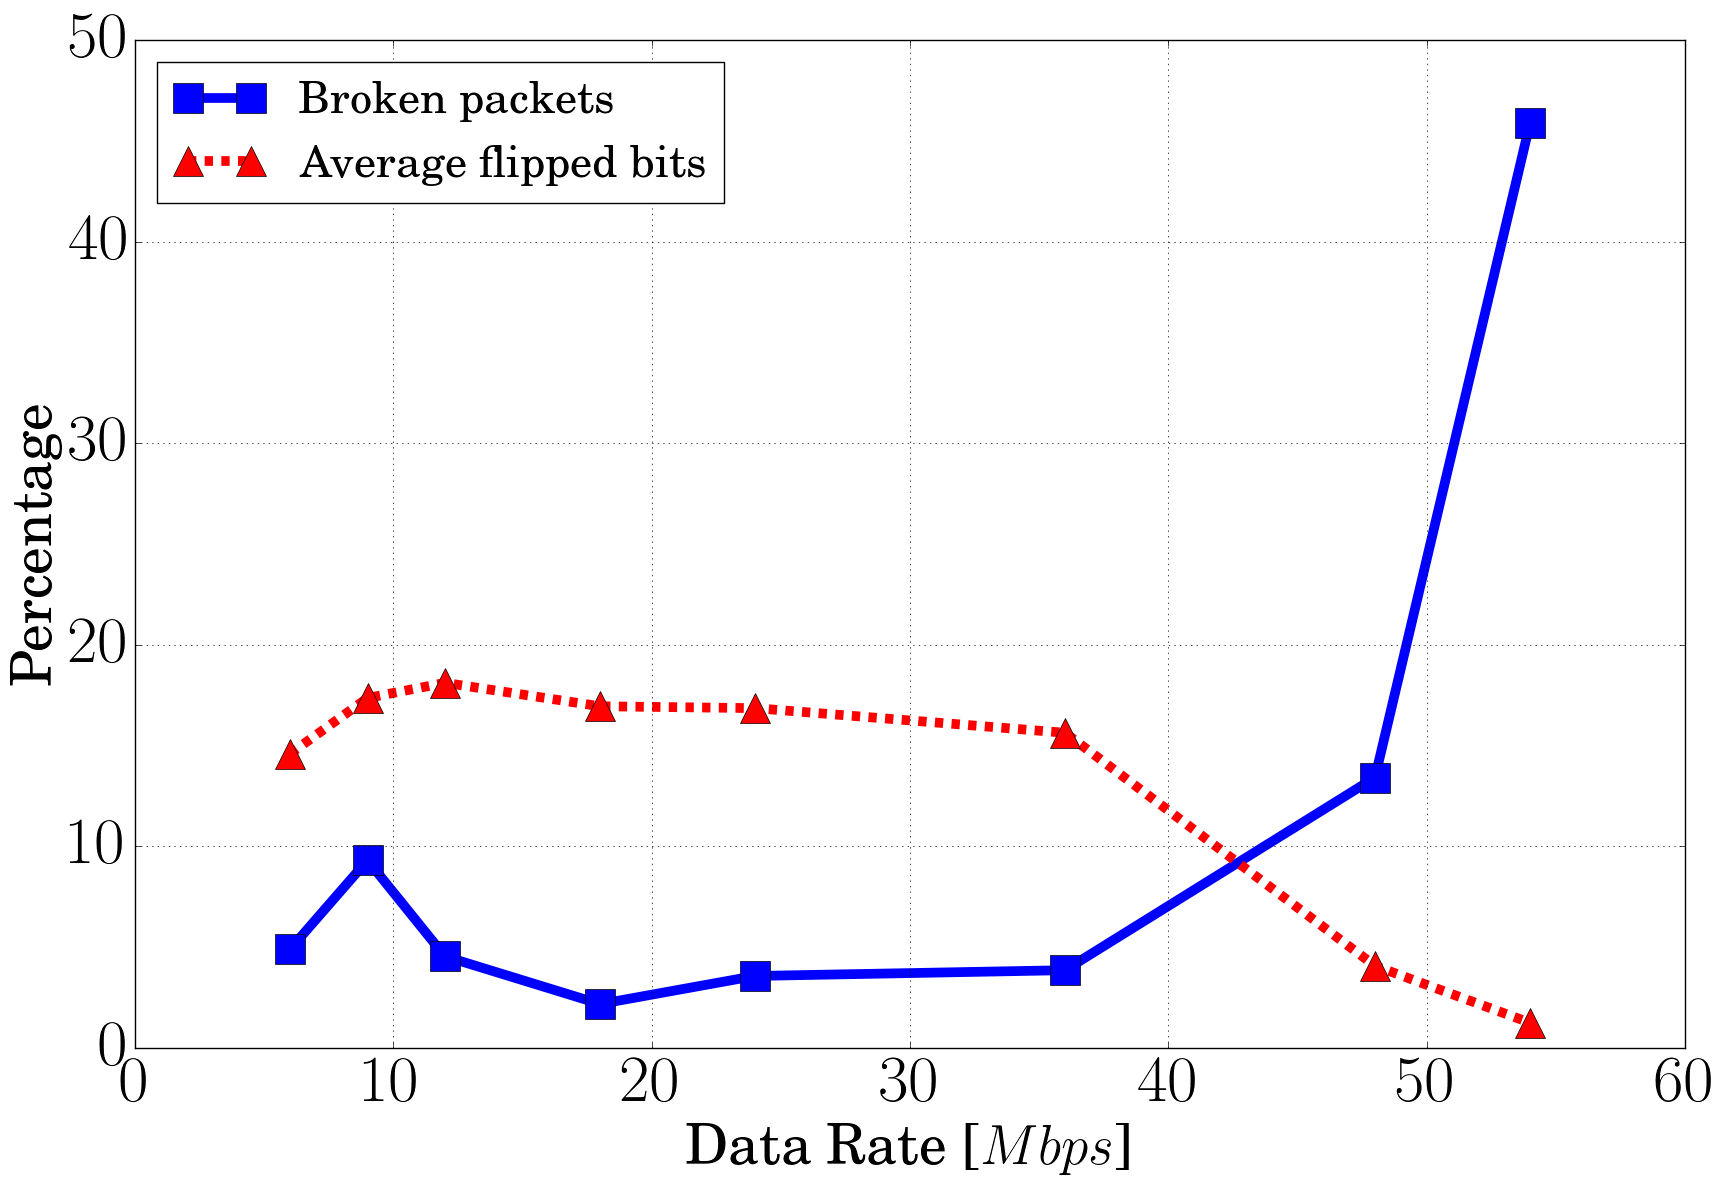

In [94]:
# -- Ploting parameters
#
######################### PLOTTING SETTINGS ################################
font_size = 48
#A small dictionary to set the font style
font = {'family': 'serif',
       'weight': 'medium',
       'style': 'normal',
       'size': font_size}
plt.rc('font', **font)
plt.rc('text', usetex=True) #For the LaTeX rendering
#
plt.rcParams['figure.figsize'] = 20, 13
plt.rc('xtick', labelsize=font_size)
plt.rc('ytick', labelsize=font_size)


plt.rcParams['lines.linewidth'] = 4
#
df = df_data_rate[['Useful_broken_packets_p','Avrg_flipped_bits_p']]
df2 = df.loc[6.0:6.0]
df2 = df2.append(df.loc[9.0:9.0])
df2 = df2.append(df.loc[12.0:54.0])
#fig = df_data_rate[['Useful_broken_packets_p','Avrg_flipped_bits_p']].plot(style=['b-o','r-o'],grid=True)
fig = df2.plot(style=['b-s','r--^'], markersize=21, linewidth=7, grid=True)

plt.legend(['Broken packets','Average flipped bits'], loc='best', fontsize=32)

plt.xlabel("Data Rate [$Mbps$]", fontsize=40)
plt.ylabel("Percentage", fontsize=40)
#
axes = plt.gca()
axes.set_xlim([0,60])


#fig2 =   prac_mean.unstack("Symbols")["Decoding_Time"].
#plot(logy=True, marker='s', markersize=15, color=colors, linewidth=5, linestyle='dashed', fontsize=31, ax = ax)
#fig1 = daprac_mean.unstack("Symbols")["Decoding_Time"].
#plot(logy=True, marker='v', markersize=15, color=colors, linewidth=5, fontsize=31,ax=ax)


#plt.setp(fig, markersize=4.0)
#plt.setp(fig)
plt.savefig("how_broken.pdf", dpi=300, format='pdf')

#plt.title('Percentage of Useful CRC-Broken Packets and Average Bits Flipped vs Data Rates. Payload size: {} bits'.format(TOTAL_BITS))

In [80]:
df = df_data_rate[['Useful_broken_packets_p','Avrg_flipped_bits_p']]

df2 = df.loc[6.0:6.0]
df2 = df2.append(df.loc[9.0:9.0])
df2 = df2.append(df.loc[12.0:54.0])
df2


,Useful_broken_packets_p,Avrg_flipped_bits_p
Data_rate,,
6.0,4.890474,14.590708
9.0,9.304482,17.356927
12.0,4.536554,18.110504
18.0,2.171734,16.948154
24.0,3.563180,16.854954
36.0,3.850510,15.633464
48.0,13.412037,4.065181
54.0,45.882163,1.241426
